This file involves the loading and processing of all ocean data: mlotst and sst

In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
import xesmf as xe
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6

# Plots

In [2]:
control_mlotst = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/processed_mlotst.nc')
control_mlotst = control_mlotst.mean('name')
control_mlotst.load()

hist_mlotst = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_hist.nc')
hist_mlotst = hist_mlotst.mean('name')
hist_mlotst.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [5.96195203, 6.20026099, 6.65958072, ..., 5.22060398, 5.37200376,
        5.5428002 ],
       [7.5986824 , 7.76984714, 7.91552484, ..., 6.20952631, 6.63741335,
        6.9950488 ],
       [6.48340418, 6.48399528, 6.48113434, ..., 6.50006703, 6.48698321,
        6.47617313]])
Coordinates:
    latitude   (lat, lon) float64 nan nan nan nan nan ... 86.99 86.92 86.8 86.61
    longitude  (lat, lon) float64 nan nan nan nan ... -5.602 2.988 11.02 18.28
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357

Text(0.5, 1.0, 'Interdecadal Control Mixed Layer Depth Variability (>25 yrs) - CMIP6 (N=19)')

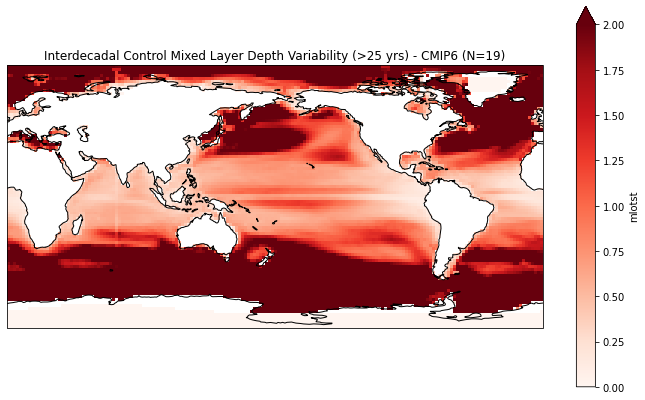

In [13]:
plt.rcParams['figure.figsize'] = [12,7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
control_mlotst.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=2)
ax.coastlines(color='black', linewidth=1)
plt.title('Interdecadal Control Mixed Layer Depth Variability (>25 yrs) - CMIP6 (N=19)')

Text(0.5, 1.0, 'Interdecadal Historical Mixed Layer Depth Variability (>25 years) - CMIP6 (N=19)')

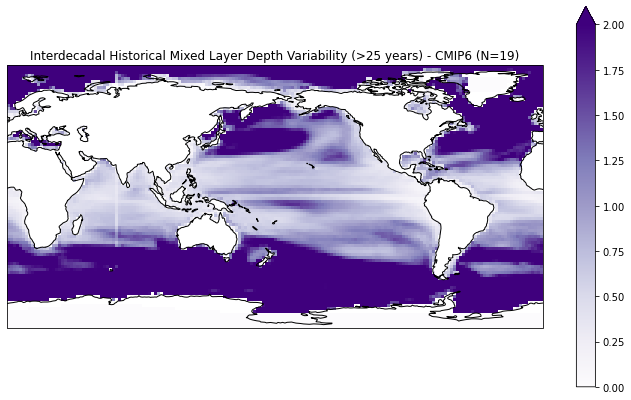

In [15]:
plt.rcParams['figure.figsize'] = [12,7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
hist_mlotst.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Purples', vmin=0, vmax=2)
ax.coastlines(color='black', linewidth=1)
plt.title('Interdecadal Historical Mixed Layer Depth Variability (>25 years) - CMIP6 (N=19)')

# Loading in data

In [2]:
# Head to google catalog to get some vertical motion data

# Read in data catalog

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


# Control MLOTST

In [10]:
# Find omega

df_hml_control = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl'")
df_hml_control = df_hml_control.drop_duplicates('source_id').head(10)
df_hml_control = df_hml_control.drop(index=45755)
df_hml_control


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9212,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,mlotst,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...,NaN,20180701
16244,CMIP,NOAA-GFDL,GFDL-ESM4,piControl,r1i1p1f1,Omon,mlotst,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...,NaN,20180701
31863,CMIP,CNRM-CERFACS,CNRM-CM6-1,piControl,r1i1p1f2,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180814
32207,CMIP,NASA-GISS,GISS-E2-1-G,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...,NaN,20180824
40214,CMIP,BCC,BCC-CSM2-MR,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...,NaN,20181015
42727,CMIP,CNRM-CERFACS,CNRM-ESM2-1,piControl,r1i1p1f2,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181115
45366,CMIP,BCC,BCC-ESM1,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...,NaN,20181218
66986,CMIP,IPSL,IPSL-CM6A-LR,piControl,r1i2p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...,NaN,20190319
67207,CMIP,NCAR,CESM2-WACCM,piControl,r1i1p1f1,Omon,mlotst,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/piContr...,NaN,20190320


In [11]:
for dataset in df_hml_control.zstore.unique():
    print(dataset)
    gcs = gcsfs.GCSFileSystem(token='anon')
    fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
    ds = xr.open_zarr(fs.get_mapper(dataset),consolidated=True)
    print(ds)

gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/mlotst/gr/v20180701/
<xarray.Dataset>
Dimensions:    (lat: 180, bnds: 2, lon: 360, time: 6000)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time       (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    mlotst     (time, lat, lon) float32 dask.array<chunksize=(670, 180, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.Dataset>
Dimensions:      (y: 294, x: 362, nvertex: 4, time: 6000, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time         (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    mlotst       (time, y, x) float32 dask.array<chunksize=(468, 294, 362), meta=np.ndarray>
Attributes: (12/57)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-CM6-1_piControl_r1i1p1f2
    activity_id:            CMIP


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.Dataset>
Dimensions:      (y: 294, x: 362, nvertex: 4, time: 6000, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time         (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    mlotst       (time, y, x) float32 dask.array<chunksize=(468, 294, 362), meta=np.ndarray>
Attributes: (12/56)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_piControl_r1i1p1f2
    activity_id:            CMIP

In [5]:
# From Ryan Abernathy's tutorial - Way 2
# Regridding advice: https://stackoverflow.com/questions/71616481/converting-from-2d-lat-lon-matrix-into-1d-lat-lon-array
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years
new_time_index

# Regridding
curvi_grid = xe.util.grid_global(2,2, lon1=360)
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]
    
dset_list_hml_control = []
for zstore in df_hml_control.zstore.unique():
    name = zstore.split('gs://cmip6/CMIP6')[1].replace('/','.')[:-1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore), consolidated=True)
    ds = rename_cmip6(ds)
    ds = ds.isel(time=slice(300,1800))
    ds_var = ds.assign(time=new_time_index)
    ds_var = ds_var.mlotst
    if 'lat' in ds.coords:
        regridder = xe.Regridder(ds_var, curvi_grid, "bilinear", ignore_degenerate=True)
        ds_rectilinear = regridder(ds_var)
        fin = ds_rectilinear.to_dataset(name='mlotst') #Name of variable - mlotst
        xin = nc_varget(fin,'lon');
        yin = nc_varget(fin,'lat');
        zin = nc_varget(fin,'mlotst');
        x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
        y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

        #new coordinates
        xout = np.arange(x0,x1+dx,dx)
        yout = np.arange(y0,y1+dx,dy)

        xm,ym = np.meshgrid(xout,yout)
        zout = np.zeros((1500,90,180))
        for t in range(len(ds_var['time'].values)):
            zo = griddata((xin.values.flatten(),yin.values.flatten()),zin.isel(time=t).values.flatten(),(xm,ym), 'nearest')
            zout[t,:,:] = zo
            if t%100==0:
                print(t)
            
        ds_regrid = xr.DataArray(zout, dims=['time','lat','lon'])
        ds_regrid.coords['lon'] = xout
        ds_regrid.coords['lat'] = yout
        ds_regrid.coords['time'] = new_time_index
        ds_interp = ds_regrid.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        dset_list_hml_control.append(ds_interp)
        print(name, 'processed')
        print(ds_interp)
    else:
        ds_var = ds_var.rename({'x':'lon', 'y':'lat'})
        ds_interp = ds_var.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        dset_list_hml_control.append(ds_interp)
        print(name, 'processed')
        print(ds_interp)

.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.mlotst.gr.v20180701
.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.mlotst.gr.v20180701 processed
<xarray.DataArray 'mlotst' (time: 1500, lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(1500, 88, 179), dtype=float32, chunksize=(670, 88, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     <U68 '.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.mlotst.gr...
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_laye

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
.CMIP.CNRM-CERFACS.CNRM-CM6-1.piControl.r1i1p1f2.Omon.mlotst.gn.v20180814 processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [35.86421967, 34.95941925, 34.82583237, ..., 36.27495575,
         37.32522583, 37.14268494],
        [31.37464714, 30.99547958, 30.88829231, ..., 33.08013153,
         32.4210701 , 32.03507996],
        [30.77065277, 30.77463722, 30.77843666, ..., 30.75943375,
         30.76066017, 30.76291847]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
       

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
.CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.r1i1p1f2.Omon.mlotst.gn.v20181115 processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [29.98419571, 31.42145348, 31.59262848, ..., 27.93704796,
         27.83479881, 28.07898521],
        [31.71488571, 31.84480286, 32.02974319, ..., 29.56868362,
         30.17036438, 30.82302475],
        [35.67639923, 36.17217255, 36.66423035, ..., 34.15082169,
         34.38127899, 34.7228241 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
      

In [6]:
CMIP_mlotst_piControl_interp = xr.concat(dset_list_hml_control, dim='name', coords='minimal', compat='override')
CMIP_mlotst_piControl_interp

<xarray.DataArray 'mlotst' (name: 9, time: 1500, lat: 88, lon: 179)>
dask.array<concatenate, shape=(9, 1500, 88, 179), dtype=float64, chunksize=(1, 191, 88, 179), chunktype=numpy.ndarray>
Coordinates:
    latitude   (lat, lon) float32 dask.array<chunksize=(88, 179), meta=np.ndarray>
    longitude  (lat, lon) float32 dask.array<chunksize=(88, 179), meta=np.ndarray>
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
  * name       (name) <U74 '.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon....
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m

In [8]:
CMIP_mlotst_piControl_interp.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_mlotst_piControl_interp_2x2.nc')

In [9]:
mlotst_ds = xr.concat(dset_list_hml_control, dim='name', coords='minimal', compat='override')
mlotst_ds

<xarray.DataArray 'mlotst' (name: 9, time: 100, lat: 88, lon: 179)>
dask.array<concatenate, shape=(9, 100, 88, 179), dtype=float64, chunksize=(1, 85, 88, 179), chunktype=numpy.ndarray>
Coordinates:
    latitude   (lat, lon) float32 dask.array<chunksize=(88, 179), meta=np.ndarray>
    longitude  (lat, lon) float32 dask.array<chunksize=(88, 179), meta=np.ndarray>
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1859-04-30
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
Dimensions without coordinates: name
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m

In [11]:
control_mlotst = mlotst_ds.mean('name').rolling(time=300, center=True).mean('time')
control_mlotst.load()

<xarray.DataArray 'mlotst' (time: 100, lat: 88, lon: 179)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    latitude   (lat, lon) float64 nan nan nan nan nan ... 86.99 86.92 86.8 86.61
    longitude  (lat, lon) float64 nan nan nan nan ... -5.602 2.988 11.02 18.28
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1859-04-30
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357

Text(0.5, 1.0, 'Interdecadal MLOTST Variability (>25 yrs) - CMIP6 (N=20)')

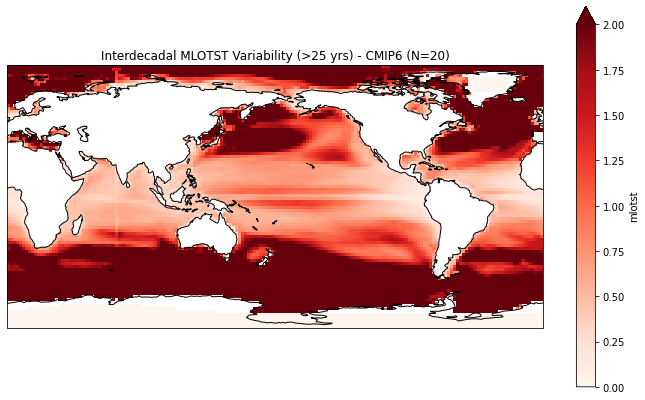

In [16]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
control_mlotst.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=2)
ax.coastlines(color='black', linewidth=1)
plt.title('Interdecadal MLOTST Variability (>25 yrs) - CMIP6 (N=20)')

In [5]:
# From Ryan Abernathy's tutorial - Way 2
# Regridding advice: https://stackoverflow.com/questions/71616481/converting-from-2d-lat-lon-matrix-into-1d-lat-lon-array
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
curvi_grid = xe.util.grid_global(2,2, lon1=360)
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]
    
dset_list_hml_control = []
for zstore in df_hml_control.zstore.unique():
    name = zstore.split('gs://cmip6/CMIP6')[1].replace('/','.')[:-1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore), consolidated=True)
    ds = rename_cmip6(ds)
    ds_mean = ds.mlotst.mean('time') 
    if 'lat' in ds.coords:
        regridder = xe.Regridder(ds_mean, curvi_grid, "bilinear", ignore_degenerate=True)
        ds_rectilinear = regridder(ds_mean)
        fin = ds_rectilinear.to_dataset(name='mlotst') #Name of variable - mlotst
        xin = nc_varget(fin,'lon');
        yin = nc_varget(fin,'lat');
        zin = nc_varget(fin,'mlotst');

        x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
        y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

        #new coordinates
        xout = np.arange(x0,x1+dx,dx)
        yout = np.arange(y0,y1+dx,dy)

        xm,ym = np.meshgrid(xout,yout)
        zo = griddata((xin.values.flatten(),yin.values.flatten()),zin.values.flatten(),(xm,ym), 'nearest')

        ds_regrid = xr.DataArray(zo, dims=['lat','lon'])
        ds_regrid.coords['lon'] = xout
        ds_regrid.coords['lat'] = yout
        ds_interp = ds_regrid.interp(lat=new_lats, lon=new_lons)
        dset_list_hml_control.append(ds_interp)
        print(name, 'processed')
        print(ds_interp)
    else:
        ds_mean = ds_mean.rename({'x':'lon', 'y':'lat'})
        ds_interp = ds_mean.interp(lat=new_lats, lon=new_lons)
        dset_list_hml_control.append(ds_interp)
        print(name, 'processed')
        print(ds_interp)

.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.mlotst.gr.v20180701
.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.mlotst.gr.v20180701 processed
<xarray.DataArray 'mlotst' (lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(88, 179), dtype=float32, chunksize=(88, 179), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
.CMIP.NOAA-GFDL.GFDL-ESM4.piControl.r1i1p1f1.Omon.mlotst.gr.v20180701
.CMIP.NOAA-GFDL.GFDL-ESM4.piControl.r1i1p1f1.Omon.mlotst.gr.v20180701 processed
<xarray.DataArray 'mlotst' (lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(88, 179), dtype=float32, chunksize=(88, 179), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
.CMIP.CNRM-CERFACS.CNRM-CM6-1.piControl.r1i1

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


.CMIP.CNRM-CERFACS.CNRM-CM6-1.piControl.r1i1p1f2.Omon.mlotst.gn.v20180814 processed
<xarray.DataArray (lat: 88, lon: 179)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [24.93519974, 24.85994911, 24.62904167, ..., 23.83546638,
        24.37977409, 24.70943642],
       [24.42627716, 24.49194527, 24.56591415, ..., 24.21473503,
        24.2718277 , 24.32227135],
       [24.33844376, 24.37408447, 24.41196823, ..., 24.20009232,
        24.23366356, 24.26792145]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
.CMIP.NASA-GISS.GISS-E2-1-G.piControl.r1i1p1f1.Omon.mlotst.gn.v20180824
.CMIP.NASA-GISS.GISS-

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

.CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.r1i1p1f2.Omon.mlotst.gn.v20181115 processed
<xarray.DataArray (lat: 88, lon: 179)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [24.84043503, 24.8471508 , 24.67775917, ..., 23.77826881,
        24.20899391, 24.52287865],
       [24.46347237, 24.52191162, 24.58599854, ..., 24.20625114,
        24.28530884, 24.34960175],
       [24.2752552 , 24.29800987, 24.32191277, ..., 24.20207214,
        24.21308327, 24.22898102]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
.CMIP.BCC.BCC-ESM1.piControl.r1i1p1f1.Omon.mlotst.gn.v20181218
.CMIP.BCC.BCC-ESM1.piControl.

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

.CMIP.MPI-M.MPI-ESM1-2-LR.piControl.r1i1p1f1.Omon.mlotst.gn.v20190710 processed
<xarray.DataArray (lat: 88, lon: 179)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [20.22597885, 19.99450302, 19.88605118, ..., 22.25600243,
        21.63947678, 21.08071327],
       [20.5511837 , 20.53665161, 20.5512085 , ..., 20.56332207,
        20.52664948, 20.53899384],
       [21.10569   , 21.01020241, 20.91498947, ..., 21.42897987,
        21.37827682, 21.29686928]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
.CMIP.MPI-M.MPI-ESM1-2-HR.piControl.r1i1p1f1.Omon.mlotst.gn.v20190710


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

.CMIP.MPI-M.MPI-ESM1-2-HR.piControl.r1i1p1f1.Omon.mlotst.gn.v20190710 processed
<xarray.DataArray (lat: 88, lon: 179)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [22.81966019, 22.26960754, 21.84864426, ..., 25.1482563 ,
        24.76116943, 24.2352829 ],
       [25.41256905, 25.25998306, 25.12150002, ..., 26.22043228,
        25.95189095, 25.76137161],
       [26.60456848, 26.46484756, 26.33246994, ..., 27.28721428,
        27.11969185, 26.94960976]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
.CMIP.CAMS.CAMS-CSM1-0.piControl.r1i1p1f1.Omon.mlotst.gn.v20190729
.CMIP.CAMS.CAMS-CSM1-0.piContr

In [6]:
mlotst_mean = xr.concat(dset_list_hml_control, dim='name', coords='minimal', compat='override')
mlotst_mean 

<xarray.DataArray 'mlotst' (name: 19, lat: 88, lon: 179)>
dask.array<concatenate, shape=(19, 88, 179), dtype=float64, chunksize=(1, 88, 179), chunktype=numpy.ndarray>
Coordinates:
    latitude   (lat, lon) float32 dask.array<chunksize=(88, 179), meta=np.ndarray>
    longitude  (lat, lon) float32 dask.array<chunksize=(88, 179), meta=np.ndarray>
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
Dimensions without coordinates: name

In [7]:
mlotst_mean = mlotst_mean.mean('name')
mlotst_mean.load()

<xarray.DataArray 'mlotst' (lat: 88, lon: 179)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [33.13558799, 32.46751307, 32.1347342 , ..., 35.52560732,
        34.88397834, 34.45573527],
       [33.38532419, 33.21346281, 33.05063981, ..., 33.69042528,
        33.65719622, 33.553534  ],
       [33.68456958, 33.79060443, 33.85688957, ..., 33.68275213,
        33.82263475, 33.71691496]])
Coordinates:
    latitude   (lat, lon) float64 nan nan nan nan nan ... 86.99 86.92 86.8 86.61
    longitude  (lat, lon) float64 nan nan nan nan ... -5.602 2.988 11.02 18.28
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357

Text(0.5, 1.0, 'MLOTST time mean (>25 yrs) - CMIP6 (N=20)')

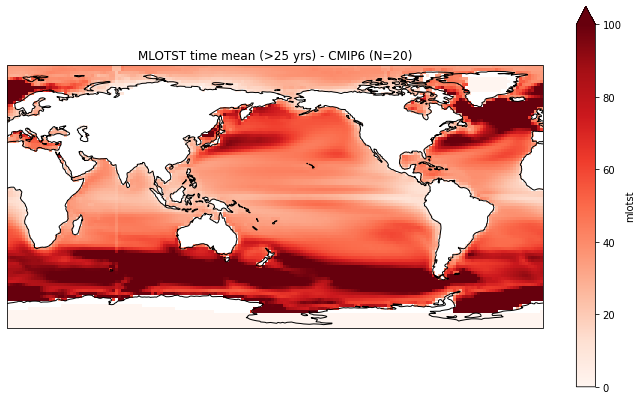

In [13]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
mlotst_mean.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=100)
ax.coastlines(color='black', linewidth=1)
plt.title('MLOTST time mean (>25 yrs) - CMIP6 (N=20)')

### HadGEM3-GC31-LL

In [4]:
# Find MLOTST for additional 6 model ensemble.

df_hml_HadGEM3_GC31_LL = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
#df_hml_HadGEM3_GC31_LL
mlotst_HadGEM3_GC31_LL = mlotst_load(df_hml_HadGEM3_GC31_LL)

HadGEM3-GC31-LL
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
HadGEM3-GC31-LL processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [30.71750832, 29.64086151, 28.25364876, ..., 37.24291229,
         35.04535294, 33.25634766],
        [31.68507385, 31.73269653, 31.76385498, ..., 31.45937347,
         31.4696579 , 31.54091835],
        [34.02612305, 34.09165192, 34.13754654, ..., 33.83340836,
         33.86871338, 33.91246033]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [    

In [18]:
df_hml_HadGEM3_GC31_LL = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'HadGEM3-GC31-LL'").head(1)
print(df_hml_HadGEM3_GC31_LL.zstore.unique())
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
ds = xr.open_zarr(fs.get_mapper(df_hml_HadGEM3_GC31_LL.zstore.unique()[0]),consolidated=True)
print(ds)

['gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piControl/r1i1p1f1/Omon/mlotst/gn/v20211103/']
<xarray.Dataset>
Dimensions:             (i: 360, j: 330, time: 24000, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 00:00:00 ... 3849-12-16 00:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(12000, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    mlotst              (time, j, i) float32 dask.array<chunksize=(225, 330, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  

In [6]:
mlotst_HadGEM3_GC31_LL.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_HadGEM3_GC31_LL_piControl_2x2.nc')

### CanESM5

In [4]:
# Find MLOTST for additional 6 model ensemble.

df_hml_CanESM5 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'CanESM5'").head(1)
#df_hml_CanESM5
mlotst_CanESM5 = mlotst_load(df_hml_CanESM5)

CanESM5
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
CanESM5 processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [48.57738113, 56.96133423, 72.45801544, ..., 60.79089737,
         49.94495392, 46.42199707],
        [47.92631912, 53.68194199, 60.33453751, ..., 48.13340759,
         45.07737732, 45.00929642],
        [75.69916534, 77.77854156, 79.31349945, ..., 63.91765976,
         67.54042816, 70.78962708]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.    

In [5]:
mlotst_CanESM5.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_CanESM5_piControl_2x2.nc')

In [19]:
df_hml_CanESM5 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'CanESM5'").head(1)
print(df_hml_CanESM5.zstore.unique())
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
ds = xr.open_zarr(fs.get_mapper(df_hml_CanESM5.zstore.unique()[0]),consolidated=True)
print(ds)

['gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Omon/mlotst/gn/v20190429/']
<xarray.Dataset>
Dimensions:             (i: 360, j: 291, time: 12000, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 5201-01-16 12:00:00 ... 6200-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(12000, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    mlotst              (time, j, i) float32 dask.array<chunksize=(211, 291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, 

### CanESM5-CanOE

In [9]:
# Find MLOTST for additional 6 model ensemble.

df_hml_CanESM5_CanOE = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'CanESM5-CanOE'").head(1)
#df_hml_CanESM5_CanOE
mlotst_CanESM5CanOE = mlotst_load(df_hml_CanESM5_CanOE)

CanESM5-CanOE
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
CanESM5-CanOE processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [62.49842453, 63.63875198, 59.1202774 , ..., 60.08398819,
         57.74235153, 59.15263367],
        [64.43428802, 65.24723816, 65.62102509, ..., 55.30196381,
         56.87231445, 59.29928589],
        [66.13974762, 66.17184448, 66.19309235, ..., 65.85865021,
         65.98265076, 66.06497192]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.     

In [20]:
df_hml_CanESM5_CanOE = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'CanESM5-CanOE'").head(1)
print(df_hml_CanESM5_CanOE.zstore.unique())
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
ds = xr.open_zarr(fs.get_mapper(df_hml_CanESM5_CanOE.zstore.unique()[0]),consolidated=True)
print(ds)

['gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piControl/r1i1p2f1/Omon/mlotst/gn/v20190429/']
<xarray.Dataset>
Dimensions:             (i: 360, j: 291, time: 6012, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 5550-01-16 12:00:00 ... 6050-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(6012, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    mlotst              (time, j, i) float32 dask.array<chunksize=(209, 291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j,

In [10]:
mlotst_CanESM5CanOE.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_CanESM5CanOE_piControl_2x2.nc')

### MPI-ESM-1-2-HAM

In [12]:
# Find MLOTST for additional 6 model ensemble.

df_hml_MPIESM12HAM = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
#df_hml_MPIESM12HAM
mlotst_MPIESM12HAM = mlotst_load(df_hml_MPIESM12HAM)

MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
MPI-ESM-1-2-HAM processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [39.63874435, 36.66211319, 34.92984772, ..., 40.33957291,
         37.88332748, 37.25049973],
        [36.01321793, 34.47758102, 32.61141205, ..., 34.647686  ,
         37.64544296, 37.38264847],
        [24.92670822, 24.50700188, 24.4896946 , ..., 28.82389641,
         28.28965378, 27.01908684]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.    

In [21]:
df_hml_MPIESM12HAM = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
print(df_hml_MPIESM12HAM.zstore.unique())
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
ds = xr.open_zarr(fs.get_mapper(df_hml_MPIESM12HAM.zstore.unique()[0]),consolidated=True)
print(ds)

['gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/piControl/r1i1p1f1/Omon/mlotst/gn/v20200120/']


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


<xarray.Dataset>
Dimensions:             (i: 256, j: 220, time: 12000, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 249 250 251 252 253 254 255
  * j                   (j) int32 0 1 2 3 4 5 6 ... 213 214 215 216 217 218 219
    latitude            (j, i) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2849-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(12000, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    mlotst              (time, j, i) float32 dask.array<chunksize=(364, 220, 256), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(220, 256, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(220, 256, 4), meta=np.ndarray>
Attributes: (1

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [13]:
mlotst_MPIESM12HAM.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_MPIESM12HAM_piControl_2x2.nc')

### FGOALS-g3

In [6]:
# Find MLOTST for additional 6 model ensemble.

df_hml_fgoals = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
#df_hml_fgoals
mlotst_fgoals = mlotst_load(df_hml_fgoals)

FGOALS-g3
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
FGOALS-g3 processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [176.77912903, 163.66094971, 152.44795227, ..., 248.12921143,
         229.49978638, 207.51657104],
        [164.02830505, 160.14544678, 156.16081238, ..., 174.46490479,
         173.18786621, 171.10369873],
        [161.34275818, 159.49571228, 157.46418762, ..., 165.89503479,
         164.86817932, 163.75584412]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.  

In [22]:
df_hml_fgoals = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'").head(1)
print(df_hml_fgoals.zstore.unique())
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
ds = xr.open_zarr(fs.get_mapper(df_hml_fgoals.zstore.unique()[0]),consolidated=True)
print(ds)

['gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/r1i1p1f1/Omon/mlotst/gn/v20191125/']
<xarray.Dataset>
Dimensions:    (i: 360, j: 218, time: 8400, bnds: 2)
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 210 211 212 213 214 215 216 217
    latitude   (j, i) float64 dask.array<chunksize=(218, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(218, 360), meta=np.ndarray>
  * time       (time) object 0200-01-16 12:00:00 ... 0899-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(8400, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    mlotst     (time, j, i) float32 dask.array<chunksize=(158, 218, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Spin-up documentation
    branch_time_in_child:   0.0
    branch_time_in_parent:  73000.

In [7]:
mlotst_fgoals.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_FGOALSg3_piControl_2x2.nc')

### E3SM-1-0

In [11]:
# Find MLOTST for additional 6 model ensemble.

df_hml_e3sm10 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'E3SM-1-0'").head(1)
#df_hml_e3sm10
mlotst_e3sm10 = mlotst_load(df_hml_e3sm10)

E3SM-1-0
E3SM-1-0 processed
<xarray.DataArray 'mlotst' (time: 1500, lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(1500, 88, 179), dtype=float32, chunksize=(618, 88, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     <U8 'E3SM-1-0'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Sigma T is potential density referenced to ocean surface.
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m


In [24]:
df_hml_e3sm10 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'E3SM-1-0'").head(1)
print(df_hml_e3sm10.zstore.unique())
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
ds = xr.open_zarr(fs.get_mapper(df_hml_e3sm10.zstore.unique()[0]),consolidated=True)
print(ds)

['gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Omon/mlotst/gr/v20200129/']
<xarray.Dataset>
Dimensions:    (lat: 180, bnds: 2, lon: 360, time: 6000)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time       (time) object 0001-01-16 12:00:00 ... 0500-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    mlotst     (time, lat, lon) float32 dask.array<chunksize=(618, 180, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Spin-up documentation
    branch_time_in_child:   0.0
    branch_time_

In [19]:
mlotst_e3sm10.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_E3SM10_piControl_2x2.nc')

In [18]:
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

zstore = df_hml_e3sm10.zstore.unique()[0]
name = zstore.split('gs://cmip6/CMIP6')[1].replace('/','.')[:-1]
ds = xr.open_zarr(fs.get_mapper(zstore), consolidated=True)
ds

<xarray.Dataset>
Dimensions:    (lat: 180, bnds: 2, lon: 360, time: 6000)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time       (time) object 0001-01-16 12:00:00 ... 0500-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    mlotst     (time, lat, lon) float32 dask.array<chunksize=(618, 180, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Spin-up documentation
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.5.0
    ...                     ...
    tracking_id:            hdl:21.14100/403841b1-bd00-4999-9d42-f77ac5fd85c3...
    variable_id:            mlotst
    variant_label:          r1i1p1f1
    status:                 2019-10-26;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/403841b1-bd00-4999-9d42-f77ac5fd85c3...
    version_id:             v20200129

### MIROC6

In [22]:
# Find MLOTST for additional 6 model ensemble.

df_hml_miroc6 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'MIROC6'").head(1)
#df_hml_miroc6
mlotst_miroc6 = mlotst_load(df_hml_miroc6)

MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.piControl.r1i1p1f1.Omon.gn.none.mlotst:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check res

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
MIROC6 processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [72.84320068, 69.40552521, 66.27391052, ..., 76.50493622,
         76.21027374, 75.69485474],
        [67.68720245, 67.73779297, 67.94206238, ..., 69.96705627,
         68.70305634, 68.12052917],
        [65.52190399, 66.19200134, 66.74408722, ..., 62.23705292,
         63.0829277 , 63.9545784 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,    

In [25]:
df_hml_miroc6 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl' & source_id == 'MIROC6'").head(1)
print(df_hml_miroc6.zstore.unique())
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
ds = xr.open_zarr(fs.get_mapper(df_hml_miroc6.zstore.unique()[0]),consolidated=True)
print(ds)

['gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r1i1p1f1/Omon/mlotst/gn/v20210129/']


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:             (y: 256, x: 360, time: 9600, bnds: 2, vertices: 4)
Coordinates:
    latitude            (y, x) float64 dask.array<chunksize=(256, 360), meta=np.ndarray>
    longitude           (y, x) float64 dask.array<chunksize=(256, 360), meta=np.ndarray>
  * time                (time) object 3200-01-16 12:00:00 ... 3999-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(9600, 2), meta=np.ndarray>
  * x                   (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    x_bnds              (x, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * y                   (y) float64 -88.0 -85.75 -85.25 ... 148.6 150.5 152.4
    y_bnds              (y, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    mlotst              (time, y, x) float32 dask.array<chunksize=(277, 256, 360), meta=np.ndarray>
    vertices_latitude   (y, x, vertices) f

In [23]:
mlotst_miroc6.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_MIROC6_piControl_2x2.nc')

## Putting 15 model ensemble together

In [48]:
mlotst_9model = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_mlotst_piControl_interp_2x2.nc')
mlotst_9model['name']

<xarray.DataArray 'name' (name: 9)>
array(['.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.mlotst.gr.v20180701',
       '.CMIP.NOAA-GFDL.GFDL-ESM4.piControl.r1i1p1f1.Omon.mlotst.gr.v20180701',
       '.CMIP.CNRM-CERFACS.CNRM-CM6-1.piControl.r1i1p1f2.Omon.mlotst.gn.v20180814',
       '.CMIP.NASA-GISS.GISS-E2-1-G.piControl.r1i1p1f1.Omon.mlotst.gn.v20180824',
       '.CMIP.BCC.BCC-CSM2-MR.piControl.r1i1p1f1.Omon.mlotst.gn.v20181015',
       '.CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.r1i1p1f2.Omon.mlotst.gn.v20181115',
       '.CMIP.BCC.BCC-ESM1.piControl.r1i1p1f1.Omon.mlotst.gn.v20181218',
       '.CMIP.IPSL.IPSL-CM6A-LR.piControl.r1i2p1f1.Omon.mlotst.gn.v20190319',
       '.CMIP.NCAR.CESM2-WACCM.piControl.r1i1p1f1.Omon.mlotst.gr.v20190320'],
      dtype=object)
Coordinates:
  * name     (name) object '.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon....

In [49]:
mlotst_9model = mlotst_9model.to_dataset('name').rename_vars({'.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.mlotst.gr.v20180701':'GFDL-CM4',
                                                          '.CMIP.NOAA-GFDL.GFDL-ESM4.piControl.r1i1p1f1.Omon.mlotst.gr.v20180701':'GFDL-ESM4',
                                                          '.CMIP.CNRM-CERFACS.CNRM-CM6-1.piControl.r1i1p1f2.Omon.mlotst.gn.v20180814':'CNRM-CM6-1',
                                                          '.CMIP.NASA-GISS.GISS-E2-1-G.piControl.r1i1p1f1.Omon.mlotst.gn.v20180824':'GISS-E2-1-G',
                                                          '.CMIP.BCC.BCC-CSM2-MR.piControl.r1i1p1f1.Omon.mlotst.gn.v20181015':'BCC-CSM2-MR',
                                                          '.CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.r1i1p1f2.Omon.mlotst.gn.v20181115':'CNRM-ESM2-1',
                                                          '.CMIP.BCC.BCC-ESM1.piControl.r1i1p1f1.Omon.mlotst.gn.v20181218':'BCC-ESM1',
                                                          '.CMIP.IPSL.IPSL-CM6A-LR.piControl.r1i2p1f1.Omon.mlotst.gn.v20190319':'IPSL-CM6A-LR',
                                                          '.CMIP.NCAR.CESM2-WACCM.piControl.r1i1p1f1.Omon.mlotst.gr.v20190320':'CESM2-WACCM'}).to_array('name')
mlotst_9model

<xarray.DataArray (name: 9, time: 1500, lat: 88, lon: 179)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [50.41090584, 52.04710674, 50.50968361, ..., 48.75899982,
          49.236413  , 46.89223766],
         [31.22230101, 32.50833845, 32.35529757, ..., 40.54614592,
          40.76375866, 39.32892752],
         [53.78388977, 52.79047012, 53.00532818, ..., 47.45863438,
          47.6057272 , 50.86550903]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [38.03953743, 37.81469536, 37.70919704, ..., 40.9728775 ,
          39.8340168 , 38.88364983],
         [40.98170757, 40.75686169, 40.58196259, ..., 42.68622303,
          42.07203102, 41.62069225],
         [43.39238262, 43.27069187, 43.17329216, ..., 44.04097748,
          43.85855961, 43.69350433]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [53.20952702, 53.05169392, 53.01519585, ..., 54.56570148,
          54.22429848, 53.73252964],
         [52.8489809 , 52.7410326 , 52.69829273, ..., 53.71188927,
          53.39556599, 53.19498539],
         [53.00887299, 52.90163422, 52.78824043, ..., 53.48878574,
          53.35057068, 53.23210239]]]])
Coordinates:
    latitude   (lat, lon) float32 ...
    longitude  (lat, lon) float32 ...
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
  * name       (name) object 'GFDL-CM4' 'GFDL-ESM4' ... 'CESM2-WACCM'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m

In [50]:
mlotst_8model = mlotst_9model.loc[['GFDL-CM4', 'GFDL-ESM4', 'CNRM-CM6-1', 'GISS-E2-1-G', 'BCC-CSM2-MR',
       'CNRM-ESM2-1', 'BCC-ESM1', 'IPSL-CM6A-LR'], :, :, :]
mlotst_8model

<xarray.DataArray (name: 8, time: 1500, lat: 88, lon: 179)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [50.41090584, 52.04710674, 50.50968361, ..., 48.75899982,
          49.236413  , 46.89223766],
         [31.22230101, 32.50833845, 32.35529757, ..., 40.54614592,
          40.76375866, 39.32892752],
         [53.78388977, 52.79047012, 53.00532818, ..., 47.45863438,
          47.6057272 , 50.86550903]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [16.42497253, 16.25806046, 16.29283333, ..., 15.45389271,
          16.14219475, 16.43963814],
         [13.53386307, 13.35031796, 13.25664711, ..., 15.25609303,
          14.92144299, 14.52639484],
         [12.55483055, 12.42837906, 12.27312279, ..., 12.82907295,
          12.82905388, 12.7852087 ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [19.8194294 , 19.52436066, 19.35075188, ..., 18.61675262,
          19.10817528, 19.7389183 ],
         [15.50763512, 15.29631424, 15.18723869, ..., 16.53617096,
          16.12218094, 15.88748455],
         [14.28213596, 14.26719093, 14.21996021, ..., 14.41526031,
          14.34896088, 14.30947971]]]])
Coordinates:
    latitude   (lat, lon) float32 nan nan nan nan nan ... 86.99 86.92 86.8 86.61
    longitude  (lat, lon) float32 nan nan nan nan ... -5.602 2.988 11.02 18.28
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
  * name       (name) object 'GFDL-CM4' 'GFDL-ESM4' ... 'IPSL-CM6A-LR'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m

In [57]:
mlotst_miroc6 = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_MIROC6_piControl_2x2.nc')
mlotst_miroc6

<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
[23628000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     object ...

In [58]:
mlotst_e3sm = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_E3SM10_piControl_2x2.nc')
mlotst_e3sm

<xarray.DataArray 'mlotst' (time: 1500, lat: 88, lon: 179)>
[23628000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     object ...
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Sigma T is potential density referenced to ocean surface.
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m

In [59]:
mlotst_fgoals = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_FGOALSg3_piControl_2x2.nc')
mlotst_fgoals

<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
[23628000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     object ...

In [60]:
mlotst_mpiesm = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_MPIESM12HAM_piControl_2x2.nc')
mlotst_mpiesm

<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
[23628000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     object ...

In [61]:
mlotst_canesm5canoe = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_CanESM5CanOE_piControl_2x2.nc')
mlotst_canesm5canoe

<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
[23628000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     object ...

In [62]:
mlotst_canesm5 = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_CanESM5_piControl_2x2.nc')
mlotst_canesm5

<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
[23628000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     object ...

In [63]:
mlotst_hadgem = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_HadGEM3_GC31_LL_piControl_2x2.nc')
mlotst_hadgem

<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
[23628000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     object ...

In [66]:
mlotst_15model = xr.concat([mlotst_8model, mlotst_miroc6, mlotst_e3sm, mlotst_fgoals, mlotst_mpiesm, mlotst_canesm5canoe, 
                            mlotst_canesm5, mlotst_hadgem], dim='name', coords='minimal', compat='override')
mlotst_15model

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [50.41090584, 52.04710674, 50.50968361, ..., 48.75899982,
          49.236413  , 46.89223766],
         [31.22230101, 32.50833845, 32.35529757, ..., 40.54614592,
          40.76375866, 39.32892752],
         [53.78388977, 52.79047012, 53.00532818, ..., 47.45863438,
          47.6057272 , 50.86550903]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [22.22373772, 19.68608475, 17.70999527, ..., 32.2755928 ,
          30.69525719, 27.84095955],
         [25.45349121, 25.06351852, 24.72636795, ..., 25.39812469,
          25.5584774 , 25.59752464],
         [24.32390594, 24.3410244 , 24.33765221, ..., 23.76138496,
          24.04454803, 24.23335075]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [31.01957703, 27.70540428, 25.07566071, ..., 39.35926056,
          38.68805313, 36.53044891],
         [35.33967209, 34.22472763, 33.02606201, ..., 34.47336197,
          35.42287064, 35.58819199],
         [32.27497101, 32.29590225, 32.31086731, ..., 31.77479553,
          32.05541229, 32.22546387]]]])
Coordinates:
    latitude   (lat, lon) float32 nan nan nan nan nan ... 86.99 86.92 86.8 86.61
    longitude  (lat, lon) float32 nan nan nan nan ... -5.602 2.988 11.02 18.28
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
  * name       (name) object 'GFDL-CM4' 'GFDL-ESM4' ... 'HadGEM3-GC31-LL'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m

In [67]:
mlotst_15model.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_mlotst_piControl_2x2_15memens.nc')

# Historical MLOTST

In [3]:
# Find omega

df_hml_hist = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'historical'")
df_hml_hist = df_hml_hist.drop_duplicates('source_id').head(10)
df_hml_hist = df_hml_hist.drop(index=45524)
df_hml_hist

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
22312,CMIP,IPSL,IPSL-CM6A-LR,historical,r8i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32468,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
37701,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
41295,CMIP,BCC,BCC-CSM2-MR,historical,r2i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181031
43547,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181129
44040,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
59475,CMIP,NCAR,CESM2,historical,r2i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
70859,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r2i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20190408
79552,CMIP,CCCma,CanESM5,historical,r11i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429


## Processing individual datasets

In [3]:
def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]

def mlotst_load(dataset):
    # From Ryan Abernathy's tutorial - Way 2
    # Regridding advice: https://stackoverflow.com/questions/71616481/converting-from-2d-lat-lon-matrix-into-1d-lat-lon-array
    gcs = gcsfs.GCSFileSystem(token='anon')
    fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

    #time index to assign model times to
    new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years

    # Regridding
    curvi_grid = xe.util.grid_global(2,2, lon1=360)
    new_lats=np.arange(-87,88,2)
    new_lons=np.arange(1,359,2)
    
    zst = dataset.zstore.unique()[0]
    name = zst.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zst), consolidated=True)
    ds = rename_cmip6(ds)
    ds = ds.isel(time=slice(300,1800))
    ds_var = ds.assign(time=new_time_index)
    ds_var = ds_var.mlotst
    if 'lat' in ds.coords:
        regridder = xe.Regridder(ds_var, curvi_grid, "bilinear", ignore_degenerate=True)
        ds_rectilinear = regridder(ds_var)
        fin = ds_rectilinear.to_dataset(name='mlotst') #Name of variable - mlotst
        xin = nc_varget(fin,'lon');
        yin = nc_varget(fin,'lat');
        zin = nc_varget(fin,'mlotst');

        x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
        y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

        #new coordinates
        xout = np.arange(x0,x1+dx,dx)
        yout = np.arange(y0,y1+dx,dy)

        xm,ym = np.meshgrid(xout,yout)
        zout = np.zeros((1500,90,180))
        for t in range(len(ds_var['time'].values)):
            zo = griddata((xin.values.flatten(),yin.values.flatten()),zin.isel(time=t).values.flatten(),(xm,ym), 'nearest')
            zout[t,:,:] = zo
            if t%100==0:
                print(t)

        ds_regrid = xr.DataArray(zout, dims=['time','lat','lon'])
        ds_regrid.coords['lon'] = xout
        ds_regrid.coords['lat'] = yout
        ds_regrid.coords['time'] = new_time_index
        ds_interp = ds_regrid.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        print(name, 'processed')
        print(ds_interp)
        return ds_interp
    else:
        ds_var = ds_var.rename({'x':'lon', 'y':'lat'})
        ds_interp = ds_var.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        print(name, 'processed')
        print(ds_interp)
        return ds_interp


### CanESM5-CanOE

In [14]:
df_hml_CanESM_CanOE.zstore.unique()

array(['gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r1i1p2f1/Omon/mlotst/gn/v20190429/'],
      dtype=object)

In [24]:
# Find MLOTST for additional 6 model ensemble.

df_hml_CanESM_CanOE = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'historical' & source_id == 'CanESM5-CanOE'").head(1)

mlotst_CanESM_CanOE = mlotst_load(df_hml_CanESM_CanOE)

CanESM5-CanOE
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
CanESM5-CanOE processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [59.71630478, 51.53593826, 45.36574173, ..., 85.34862518,
         82.19345093, 75.74291992],
        [65.71076202, 64.79279327, 63.36951447, ..., 67.18984985,
         66.9127121 , 66.56882477],
        [47.60455704, 45.9920311 , 44.41556931, ..., 52.45339966,
         51.58666992, 50.49160004]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.     

In [27]:
mlotst_CanESM_CanOE.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_CanESM5_CanOE_historical_2x2.nc')

### HadGEM3-GC31-LL

In [25]:
df_hml_HadGEM3 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'historical' & source_id == 'HadGEM3-GC31-LL'").head(1)
df_hml_HadGEM3

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
209911,CMIP,MOHC,HadGEM3-GC31-LL,historical,r2i1p1f3,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/his...,NaN,20190624


In [43]:
mlotst_HadGEM3 = mlotst_load(df_hml_HadGEM3)

HadGEM3-GC31-LL
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
HadGEM3-GC31-LL processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [35.17941284, 31.54288864, 29.11717415, ..., 46.38370514,
         44.62517548, 42.06068039],
        [38.83982468, 38.47045135, 38.3572731 , ..., 38.51367188,
         38.58776474, 38.82282257],
        [33.87438202, 33.51508331, 33.22222137, ..., 35.89838791,
         35.28991318, 34.72009659]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [    

In [45]:
mlotst_HadGEM3.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_HadGEM3GC31LL_historical_2x2.nc')

### MPI-ESM-1-2-HAM

In [34]:
df_MPIESM = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'historical' & source_id == 'MPI-ESM-1-2-HAM'").head(1)
df_MPIESM

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
210805,CMIP,HAMMOZ-Consortium,MPI-ESM-1-2-HAM,historical,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ES...,NaN,20190627


In [35]:
mlotst_MPIESM = mlotst_load(df_MPIESM)

MPI-ESM-1-2-HAM
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
MPI-ESM-1-2-HAM processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [23.56077957, 24.40001869, 26.27940369, ..., 26.46932602,
         25.27733421, 22.77579117],
        [22.99246025, 26.37990952, 25.80988312, ..., 22.67910957,
         20.37877274, 17.64514351],
        [24.64378166, 24.6110096 , 24.58629608, ..., 25.38896561,
         24.94527817, 24.73104095]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0. 

In [37]:
mlotst_MPIESM.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_MPIESM12HAM_historical_2x2.nc')

### GFDL-ESM4

In [40]:
df_GFDL = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'historical' & source_id == 'GFDL-ESM4'").head(1)
df_GFDL

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
244939,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726


In [41]:
mlotst_GFDL = mlotst_load(df_GFDL)

GFDL-ESM4
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
GFDL-ESM4 processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [60.94386673, 54.70828629, 47.66192245, ..., 60.12849426,
         62.94272232, 66.0358429 ],
        [49.51039505, 45.09153366, 43.0818367 , ..., 68.77980804,
         71.31156921, 68.79348755],
        [57.59566879, 56.06650543, 54.03113174, ..., 55.35520935,
         56.56318665, 57.7401123 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.

In [42]:
mlotst_GFDL.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_GFDLESM4_historical_2x2.nc')

### NESM3

In [4]:
df_NESM3 = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'historical' & source_id == 'NESM3'").head(1)
df_NESM3

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
215283,CMIP,NUIST,NESM3,historical,r3i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/NUIST/NESM3/historical/r...,NaN,20190703


In [5]:
mlotst_NESM3 = mlotst_load(df_NESM3)

NESM3
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
NESM3 processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 9.34616661,  7.36560965, 10.82821941, ..., 12.83914948,
         12.83914948, 12.83914948],
        [27.94629288, 27.94629288, 27.94629288, ..., 25.80350494,
         27.62359047, 27.94629288],
        [31.91929054, 29.96685219, 28.03943253, ..., 36.71212387,
         36.71212387, 35.89225388]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        

In [6]:
mlotst_NESM3.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_NESM3_historical_2x2.nc')

### UKESM1-0-LL

In [4]:
df_UKESM = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'historical' & source_id == 'UKESM1-0-LL'").head(1)
df_UKESM

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
206080,CMIP,MOHC,UKESM1-0-LL,historical,r6i1p1f3,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190604


In [5]:
mlotst_UKESM = mlotst_load(df_UKESM)

UKESM1-0-LL
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
UKESM1-0-LL processed
<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [40.1240387 , 38.32839584, 37.58552551, ..., 43.31975937,
         44.01899338, 43.20565414],
        [52.73364258, 51.98277283, 51.22793198, ..., 51.70829773,
         52.53554916, 52.75680542],
        [53.25811386, 53.21247864, 53.17128372, ..., 53.87790298,
         53.56559372, 53.36054993]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [        nan,

In [6]:
mlotst_UKESM.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_UKESM10LL_historical_2x2.nc')

## 9 Member Ensemble

In [ ]:
# From Ryan Abernathy's tutorial - Way 2
# Regridding advice: https://stackoverflow.com/questions/71616481/converting-from-2d-lat-lon-matrix-into-1d-lat-lon-array
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years
new_time_index

# Regridding
curvi_grid = xe.util.grid_global(2,2, lon1=360)
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]
    
dset_list_hml_hist = []
for zstore in df_hml_hist.zstore.unique():
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore), consolidated=True)
    ds = rename_cmip6(ds)
    ds = ds.isel(time=slice(300,1800))
    ds_var = ds.assign(time=new_time_index)
    ds_var = ds_var.mlotst
    if 'lat' in ds.coords:
        regridder = xe.Regridder(ds_var, curvi_grid, "bilinear", ignore_degenerate=True)
        ds_rectilinear = regridder(ds_var)
        fin = ds_rectilinear.to_dataset(name='mlotst') #Name of variable - mlotst
        xin = nc_varget(fin,'lon');
        yin = nc_varget(fin,'lat');
        zin = nc_varget(fin,'mlotst');

        x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
        y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

        #new coordinates
        xout = np.arange(x0,x1+dx,dx)
        yout = np.arange(y0,y1+dx,dy)

        xm,ym = np.meshgrid(xout,yout)
        zout = np.zeros((1500,90,180))
        for t in range(len(ds_var['time'].values)):
            zo = griddata((xin.values.flatten(),yin.values.flatten()),zin.isel(time=t).values.flatten(),(xm,ym), 'nearest')
            zout[t,:,:] = zo
            if t%100==0:
                print(t)
                
        ds_regrid = xr.DataArray(zout, dims=['time','lat','lon'])
        ds_regrid.coords['lon'] = xout
        ds_regrid.coords['lat'] = yout
        ds_regrid.coords['time'] = new_time_index
        ds_interp = ds_regrid.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        dset_list_hml_hist.append(ds_interp)
        print(name, 'processed')
        print(ds_interp)
    else:
        ds_var = ds_var.rename({'x':'lon', 'y':'lat'})
        ds_interp = ds_var.interp(lat=new_lats, lon=new_lons)
        ds_interp['name'] = name
        dset_list_hml_hist.append(ds_interp)
        print(name, 'processed')
        print(ds_interp)

In [5]:
CMIP_mlotst_hist_interp = xr.concat(dset_list_hml_hist, dim='name', coords='minimal', compat='override')
CMIP_mlotst_hist_interp.load()

<xarray.DataArray (name: 9, time: 1500, lat: 88, lon: 179)>
array([[[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [ 17.01635361,  16.03998375,  16.32410812, ...,  26.29211617,
           24.24300957,  21.25788116],
         [ 14.95782566,  15.11154652,  15.32291794, ...,  17.31301689,
           16.03644562,  15.49049759],
         [ 14.66462231,  14.5903511 ,  14.50779343, ...,  15.34755516,
           15.03311539,  14.81964779]],

        [[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
...
         [ 35.66253281,  33.57178497,  29.40210724, ...,  37.47640228,
           37.74918365,  37.86175919],
         [ 31.98886681,  31.23908234,  30.41943932, ...,  33.80157471,
           33.67768097,  33.21307755],
         [ 33.49114227,  33.46652985,  33.4388504 , ...,  33.54363251,
           33.54611588,  33.53768158]],

        [[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         ...,
         [ 35.51063919,  30.17873192,  25.40619659, ...,  43.23965836,
           43.46556854,  42.64061737],
         [ 35.92930222,  35.87836456,  35.80714798, ...,  36.84175491,
           36.46561813,  36.28324127],
         [ 42.51741028,  42.43287277,  42.36470032, ...,  42.71250916,
           42.69617462,  42.6608429 ]]]])
Coordinates:
    latitude   (lat, lon) float64 nan nan nan nan nan ... 86.99 86.92 86.8 86.61
    longitude  (lat, lon) float64 nan nan nan nan ... -5.602 2.988 11.02 18.28
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
  * name       (name) <U80 '.CMIP.IPSL.IPSL-CM6A-LR.historical.r8i1p1f1.Omon....

In [6]:
CMIP_mlotst_hist_interp.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_mlotst_hist_interp_2x2.nc')

## Putting 15 Member Ensemble Together

In [7]:
mlotst_9memens = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_mlotst_hist_interp_2x2.nc')

In [8]:
mlotst_MPIESM = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_MPIESM12HAM_historical_2x2.nc')

In [9]:
mlotst_CANESMCANOE = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_CanESM5_CanOE_historical_2x2.nc')

In [10]:
mlotst_HADGEM = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_HadGEM3GC31LL_historical_2x2.nc')

In [11]:
mlotst_GFDL = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_GFDLESM4_historical_2x2.nc')

In [12]:
mlotst_NESM = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/mlotst_NESM3_historical_2x2.nc')

In [13]:
mlotst_15memens = xr.concat([mlotst_9memens, mlotst_MPIESM, mlotst_CANESMCANOE, mlotst_HADGEM, mlotst_GFDL, mlotst_NESM, 
                            mlotst_UKESM], dim='name', coords='minimal', compat='override')
mlotst_15memens

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [17.01635361, 16.03998375, 16.32410812, ..., 26.29211617,
          24.24300957, 21.25788116],
         [14.95782566, 15.11154652, 15.32291794, ..., 17.31301689,
          16.03644562, 15.49049759],
         [14.66462231, 14.5903511 , 14.50779343, ..., 15.34755516,
          15.03311539, 14.81964779]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [24.56061172, 23.84238052, 23.23916054, ..., 30.89407539,
          29.08599472, 27.11272049],
         [20.52496529, 20.27659988, 20.02924919, ..., 21.15047455,
          20.83517838, 20.74583435],
         [21.01874733, 21.01875114, 21.06918526, ..., 21.01873207,
          21.01873779, 21.01874352]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [25.68753052, 25.81141472, 26.04459953, ..., 28.77454567,
          27.24700356, 26.28536797],
         [23.17504883, 23.55902672, 23.90402412, ..., 22.99147034,
          22.92484665, 22.99116898],
         [27.11617851, 27.44353104, 27.7526989 , ..., 25.86957359,
          26.22318268, 26.55505753]]]])
Coordinates:
    latitude   (lat, lon) float64 ...
    longitude  (lat, lon) float64 ...
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
  * name       (name) object '.CMIP.IPSL.IPSL-CM6A-LR.historical.r8i1p1f1.Omo...

In [15]:
mlotst_15memens = mlotst_15memens.to_dataset('name').rename_vars({'.CMIP.IPSL.IPSL-CM6A-LR.historical.r8i1p1f1.Omon.mlotst.gn.v20180803':'IPSL-CM6A-LR',
                                                          '.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f1.Omon.mlotst.gn.v20180827':'GISS-E2-1-G',
                                                          '.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.Omon.mlotst.gn.v20180917':'CNRM-CM6-1',
                                                          '.CMIP.BCC.BCC-CSM2-MR.historical.r2i1p1f1.Omon.mlotst.gn.v20181031':'BCC-CSM2-MR',
                                                          '.CMIP.BCC.BCC-ESM1.historical.r1i1p1f1.Omon.mlotst.gn.v20181129':'BCC-ESM1',
                                                          '.CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Omon.mlotst.gn.v20181206':'CNRM-ESM2-1',
                                                          '.CMIP.NCAR.CESM2.historical.r2i1p1f1.Omon.mlotst.gn.v20190308':'CESM2',
                                                          '.CMIP.EC-Earth-Consortium.EC-Earth3.historical.r2i1p1f1.Omon.mlotst.gn.v20190408':'EC-Earth3',
                                                          '.CMIP.CCCma.CanESM5.historical.r11i1p1f1.Omon.mlotst.gn.v20190429':'CanESM5'}).to_array('name')
mlotst_15memens

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [17.01635361, 16.03998375, 16.32410812, ..., 26.29211617,
          24.24300957, 21.25788116],
         [14.95782566, 15.11154652, 15.32291794, ..., 17.31301689,
          16.03644562, 15.49049759],
         [14.66462231, 14.5903511 , 14.50779343, ..., 15.34755516,
          15.03311539, 14.81964779]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [24.56061172, 23.84238052, 23.23916054, ..., 30.89407539,
          29.08599472, 27.11272049],
         [20.52496529, 20.27659988, 20.02924919, ..., 21.15047455,
          20.83517838, 20.74583435],
         [21.01874733, 21.01875114, 21.06918526, ..., 21.01873207,
          21.01873779, 21.01874352]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [25.68753052, 25.81141472, 26.04459953, ..., 28.77454567,
          27.24700356, 26.28536797],
         [23.17504883, 23.55902672, 23.90402412, ..., 22.99147034,
          22.92484665, 22.99116898],
         [27.11617851, 27.44353104, 27.7526989 , ..., 25.86957359,
          26.22318268, 26.55505753]]]])
Coordinates:
    latitude   (lat, lon) float64 nan nan nan nan nan ... 86.99 86.92 86.8 86.61
    longitude  (lat, lon) float64 nan nan nan nan ... -5.602 2.988 11.02 18.28
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
  * name       (name) object 'IPSL-CM6A-LR' 'GISS-E2-1-G' ... 'UKESM1-0-LL'

In [16]:
mlotst_15memens.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_mlotst_historical_2x2_15memens.nc')

In [9]:
mlotst_hist_ds = xr.concat(dset_list_hml_hist, dim='name', coords='minimal', compat='override')
mlotst_hist_ds.load()

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (name: 19, lat: 88, lon: 179)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [1.01364493, 1.08348525, 1.42560422, ..., 1.84918368,
         1.63187253, 1.32764113],
        [0.89663613, 1.1014291 , 1.32527173, ..., 0.99511474,
         0.89351076, 0.8610633 ],
        [1.04726529, 1.16667652, 1.30580235, ..., 0.80606419,
         0.79835606, 0.83466017]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [3.26081192, 3.3686645 , 3.14143634, ..., 2.27929974,
         2.35874605, 2.74544239],
        [2.51742554, 2.70410895, 2.82167697, ..., 2.21088648,
         2.08206582, 2.18228102],
        [2.61793756, 2.60353231, 2.5458076 , ..., 2.71244025,
         2.72150326, 2.66646457]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.96979684, 0.94266462, 0.91270977, ..., 1.06753969,
         1.04415512, 1.01921666],
        [0.79657811, 0.77457041, 0.75306392, ..., 0.86805761,
         0.8492198 , 0.83210301],
        [0.50856531, 0.49205732, 0.47533193, ..., 0.58397037,
         0.56520957, 0.54610997]]])
Coordinates:
    latitude   (lat, lon) float64 nan nan nan nan nan ... 86.99 86.92 86.8 86.61
    longitude  (lat, lon) float64 nan nan nan nan ... -5.602 2.988 11.02 18.28
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
Dimensions without coordinates: name

In [10]:
mlotst_hist_ds.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/mlotst_hist.nc')

# Control SST

In [3]:
# Find SST

df_sst_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl'")
df_sst_control = df_sst_control.drop_duplicates('source_id').head(23)
df_sst_control = df_sst_control.drop(index=44330)
df_sst_control = df_sst_control.drop(index=55630)
df_sst_control = df_sst_control.drop(index=67594)
df_sst_control = df_sst_control.drop(index=67702)
#df_sst_control = df_sst_control.drop(index=246458)
#df_sst_control = df_sst_control.drop(index=253865)
#df_sst_control = df_sst_control.drop(index=375351)
#df_sst_control = df_sst_control.drop(index=385525)
#df_sst_control = df_sst_control.drop(index=416429)
df_sst_control = df_sst_control.drop(index=75733)
df_sst_control = df_sst_control.drop(index=206179)
df_sst_control = df_sst_control.drop(index=209012)
df_sst_control = df_sst_control.drop(index=217984)
df_sst_control = df_sst_control.drop(index=236032)
df_sst_control = df_sst_control.drop(index=237883)
df_sst_control

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9418,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...,NaN,20180701
18366,CMIP,NOAA-GFDL,GFDL-ESM4,piControl,r1i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...,NaN,20180701
31900,CMIP,CNRM-CERFACS,CNRM-CM6-1,piControl,r1i1p1f2,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180814
32184,CMIP,NASA-GISS,GISS-E2-1-G,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...,NaN,20180824
40419,CMIP,BCC,BCC-CSM2-MR,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...,NaN,20181016
42780,CMIP,CNRM-CERFACS,CNRM-ESM2-1,piControl,r1i1p1f2,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181115
44600,CMIP,BCC,BCC-ESM1,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...,NaN,20181214
66921,CMIP,IPSL,IPSL-CM6A-LR,piControl,r1i2p1f1,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...,NaN,20190319
87889,CMIP,CCCma,CanESM5-CanOE,piControl,r1i1p2f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piCo...,NaN,20190429
90064,CMIP,CCCma,CanESM5,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...,NaN,20190429


In [7]:
for dataset in df_sst_control.zstore.unique():
    print(dataset)
    gcs = gcsfs.GCSFileSystem(token='anon')
    fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
    ds = xr.open_zarr(fs.get_mapper(dataset),consolidated=True)
    print(ds)

gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Amon/ts/gr1/v20180701/
<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 6000)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Data variables:
    ts         (time, lat, lon) float32 dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_paren

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256, time: 6000)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time     (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
Data variables:
    ts       (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
Attributes: (12/57)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-CM6-1_piControl_r1i1p1f2
    activity_id:            CMIP
    arpege_minor_version:   6.3.1
    branch_method:          standard
    ...                     ...
    variant_info:           . Information provided by this attribute may in s...
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/03bd14a8-aaaf-

<xarray.Dataset>
Dimensions:    (lat: 64, bnds: 2, lon: 128, time: 12000)
Coordinates:
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
  * time       (time) object 5201-01-16 12:00:00 ... 6200-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(12000, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    ts         (time, lat, lon) float32 dask.array<chunksize=(600, 64, 128), meta=np.ndarray>
Attributes: (12/56)
    CCCma_model_hash:            24718c8346665b218729640ffe79d263b76456c4
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-pictrl
    Conventions:             

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.Dataset>
Dimensions:    (lat: 96, bnds: 2, lon: 192, time: 9360)
Coordinates:
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2629-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(9360, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    ts         (time, lat, lon) float32 dask.array<chunksize=(1482, 96, 192), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.5.0
    ...                     ...
    title:              

### Loading MIROC6

In [30]:
df_sst_miroc6 = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl' & source_id == 'MIROC6'")
df_sst_miroc6

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
44330,CMIP,MIROC,MIROC6,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...,NaN,20181212


In [26]:
df_sst_miroc6 = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl' & source_id == 'MIROC6'")
print(df_sst_miroc6.zstore.unique())
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
ds = xr.open_zarr(fs.get_mapper(df_sst_miroc6.zstore.unique()[0]),consolidated=True)
print(ds)

['gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r1i1p1f1/Amon/ts/gn/v20181212/']


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


<xarray.Dataset>
Dimensions:    (lat: 128, bnds: 2, lon: 256, time: 9600)
Coordinates:
  * lat        (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
  * time       (time) object 3200-01-16 12:00:00 ... 3999-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(9600, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    ts         (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  365242.0
    cmor_version:           3.3.2
    ...                     ...
    tracking_id

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [40]:
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1800) #125 years

# Regridding
curvi_grid = xe.util.grid_global(2,2, lon1=360)
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

zst_m = df_sst_miroc6.zstore.unique()[0]
name = zst_m.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
name_list = name.split('.')
name_miroc6 = name_list[1]
print(name_miroc6)
ds_miroc6 = xr.open_zarr(fs.get_mapper(zst_m), consolidated=True)
ds_sel_miroc6 = ds_miroc6.isel(time=slice(300,2100))
ds_surface_interp_miroc6 = ds_sel_miroc6.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
ds_sst_miroc6 = ds_surface_interp_miroc6.ts
ds_sst_miroc6['name'] = name_miroc6
ds_sst_miroc6

MIROC6


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'ts' (time: 1800, lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(1800, 88, 179), dtype=float32, chunksize=(600, 88, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2000-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     <U6 'MIROC6'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Temperature of the lower boundary of the atmosphere
    long_name:      Surface Temperature
    original_name:  GRTS
    standard_name:  surface_temperature
    units:          K

### Loading FGOALS-g3

In [25]:
df_sst_fgoals = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'")
df_sst_fgoals

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
254979,CMIP,CAS,FGOALS-g3,piControl,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/...,NaN,20190818


In [27]:
df_sst_fgoals = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'piControl' & source_id == 'FGOALS-g3'")
print(df_sst_fgoals.zstore.unique())
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
ds = xr.open_zarr(fs.get_mapper(df_sst_fgoals.zstore.unique()[0]),consolidated=True)
print(ds)

['gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/piControl/r1i1p1f1/Amon/ts/gn/v20190818/']
<xarray.Dataset>
Dimensions:    (lat: 80, bnds: 2, lon: 180, time: 8400)
Coordinates:
  * lat        (lat) float64 -90.0 -84.82 -80.72 -77.22 ... 80.72 84.82 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(80, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * time       (time) object 0200-01-16 12:00:00 ... 0899-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(8400, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    ts         (time, lat, lon) float32 dask.array<chunksize=(1730, 80, 180), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_ve

In [41]:
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1800) #125 years

# Regridding
curvi_grid = xe.util.grid_global(2,2, lon1=360)
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

zst_f = df_sst_fgoals.zstore.unique()[0]
name = zst_f.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
name_list = name.split('.')
name_fgoals = name_list[1]
print(name_fgoals)
ds_fgoals = xr.open_zarr(fs.get_mapper(zst_f), consolidated=True)
ds_sel_fgoals = ds_fgoals.isel(time=slice(300,2100))
ds_surface_interp_fgoals = ds_sel_fgoals.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
ds_sst_fgoals = ds_surface_interp_fgoals.ts
ds_sst_fgoals['name'] = name_fgoals
ds_sst_fgoals

FGOALS-g3


<xarray.DataArray 'ts' (time: 1800, lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(1800, 88, 179), dtype=float32, chunksize=(1430, 88, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2000-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     <U9 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean (interval: 10 minutes)
    comment:        Temperature of the lower boundary of the atmosphere
    long_name:      Surface Temperature
    standard_name:  surface_temperature
    units:          K

In [1]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1800) #150 years
new_time_index
    
dset_list_sst = []
for zstore in df_sst_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,2100))
    ds_surface_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_sst = ds_surface_interp.ts
    ds_sst['name'] = name # Creating a new dimension for each ensemble member
    dset_list_sst.append(ds_sst)

NameError: name 'gcsfs' is not defined

In [43]:
dset_list_sst.append(ds_sst_miroc6)
dset_list_sst.append(ds_sst_fgoals)

In [44]:
print(dset_list_sst)

[<xarray.DataArray 'ts' (time: 1800, lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(1800, 88, 179), dtype=float32, chunksize=(600, 88, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2000-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     <U8 'GFDL-CM4'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Temperature
    original_name:  ts
    standard_name:  surface_temperature
    units:          K, <xarray.DataArray 'ts' (time: 1800, lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(1800, 88, 179), dtype=float32, chunksize=(600, 88, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2000-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -

## 37 Models

In [17]:
CMIP_sst_piControl_interp_37memens = xr.concat(dset_list_sst, dim='name', coords='minimal', compat='override')
CMIP_sst_piControl_interp_37memens.load()

<xarray.DataArray 'ts' (name: 37, time: 1800, lat: 88, lon: 179)>
array([[[[243.18496246, 243.0430336 , 242.90864563, ..., 243.75744705,
          243.6136322 , 243.47025681],
         [243.91621094, 243.58426437, 243.37599564, ..., 245.18914566,
          244.86694336, 244.54597549],
         [245.59149551, 245.1326683 , 244.65911102, ..., 247.68568878,
          247.14878464, 246.61694489],
         ...,
         [239.55025787, 239.92131195, 240.25101852, ..., 237.72741852,
          237.87510681, 238.06498566],
         [238.32813339, 238.6320961 , 238.78931427, ..., 237.56899948,
          237.70903015, 237.84785614],
         [236.66961594, 236.70400772, 236.74081421, ..., 236.53036346,
          236.56542206, 236.60032578]],

        [[231.3177597 , 231.15438766, 231.01077652, ..., 231.97694626,
          231.81131363, 231.64621048],
         [232.09978867, 231.65678024, 231.46744919, ..., 233.87158051,
          233.43950653, 233.00966873],
         [234.51739807, 234.01972885, 233.50682068, ..., 237.02090225,
          236.37061691, 235.73139725],
...
         [246.73228875, 246.78025914, 246.82822954, ..., 245.80713801,
          245.96445282, 246.26199246],
         [246.76072876, 246.85212297, 246.9435064 , ..., 246.27760565,
          246.40258096, 246.52755747],
         [245.69928895, 245.72308256, 245.74687474, ..., 245.63564887,
          245.65043563, 245.66521303]],

        [[234.72278398, 234.6061818 , 234.48957962, ..., 235.46344782,
          235.26847681, 235.07351971],
         [234.66878582, 234.43498296, 234.20117651, ..., 236.18285032,
          235.78366301, 235.38447301],
         [236.78568   , 236.29866619, 235.81165324, ..., 238.93767971,
          238.38312612, 237.84155758],
         ...,
         [243.77237833, 243.68707863, 243.60177717, ..., 243.08722148,
          243.1222629 , 243.3993726 ],
         [242.1851571 , 242.16459377, 242.14403043, ..., 241.9941395 ,
          242.05165165, 242.1091683 ],
         [241.45662686, 241.52207014, 241.58752868, ..., 241.35445859,
          241.37429612, 241.39413365]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2000-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U16 'GFDL-CM4' 'GFDL-ESM4' ... 'TaiESM1' 'EC-Earth3-Veg-LR'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Temperature
    original_name:  ts
    standard_name:  surface_temperature
    units:          K

In [18]:
CMIP_sst_piControl_interp_37memens.to_netcdf('~/a/processed_var_data/CMIP_sst_piControl_2x2_37memens.nc')

## 15 model ensemble

In [45]:
CMIP_sst_piControl_interp = xr.concat(dset_list_sst, dim='name', coords='minimal', compat='override')
CMIP_sst_piControl_interp.load()

<xarray.DataArray 'ts' (name: 15, time: 1800, lat: 88, lon: 179)>
array([[[[243.18496246, 243.0430336 , 242.90864563, ..., 243.75744705,
          243.6136322 , 243.47025681],
         [243.91621094, 243.58426437, 243.37599564, ..., 245.18914566,
          244.86694336, 244.54597549],
         [245.59149551, 245.1326683 , 244.65911102, ..., 247.68568878,
          247.14878464, 246.61694489],
         ...,
         [239.55025787, 239.92131195, 240.25101852, ..., 237.72741852,
          237.87510681, 238.06498566],
         [238.32813339, 238.6320961 , 238.78931427, ..., 237.56899948,
          237.70903015, 237.84785614],
         [236.66961594, 236.70400772, 236.74081421, ..., 236.53036346,
          236.56542206, 236.60032578]],

        [[231.3177597 , 231.15438766, 231.01077652, ..., 231.97694626,
          231.81131363, 231.64621048],
         [232.09978867, 231.65678024, 231.46744919, ..., 233.87158051,
          233.43950653, 233.00966873],
         [234.51739807, 234.01972885, 233.50682068, ..., 237.02090225,
          236.37061691, 235.73139725],
...
         [236.21630066, 236.41590355, 236.61564204, ..., 235.54121697,
          235.48484011, 235.62871534],
         [235.7615734 , 235.75446825, 235.68558256, ..., 235.16832016,
          235.07757449, 235.21519248],
         [233.91476264, 233.92667082, 233.89350286, ..., 233.50961941,
          233.46821828, 233.55730458]],

        [[242.75259891, 242.68326074, 242.66877344, ..., 243.78897623,
          243.58508976, 243.22465703],
         [242.03332321, 241.91772399, 241.89358867, ..., 243.7606035 ,
          243.42067573, 242.82000536],
         [243.07760255, 242.78785914, 242.30024329, ..., 245.10339405,
          244.47122299, 243.80644261],
         ...,
         [234.80622118, 235.27589037, 235.74677416, ..., 232.50746223,
          233.02922355, 233.63228052],
         [231.77566348, 232.06172021, 232.25882711, ..., 229.94323198,
          230.36028449, 230.8487199 ],
         [229.72607924, 229.92453213, 230.05266565, ..., 228.49337449,
          228.76906986, 229.07961463]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2000-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-CM4' 'GFDL-ESM4' ... 'MIROC6' 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Temperature
    original_name:  ts
    standard_name:  surface_temperature
    units:          K

In [46]:
CMIP_sst_piControl_interp.to_netcdf('~/a/processed_var_data/CMIP_sst_piControl_interp_2x2_15memens_3.nc')

# SST Historical

In [4]:
ecearth3_sst_hist = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'historical' & source_id == 'EC-Earth3'")
ecearth3_sst_hist.iloc[0]

activity_id                                                    CMIP
institution_id                                  EC-Earth-Consortium
source_id                                                 EC-Earth3
experiment_id                                            historical
member_id                                                  r9i1p1f1
table_id                                                       Amon
variable_id                                                      ts
grid_label                                                       gr
zstore            gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...
dcpp_init_year                                                  NaN
version                                                    20200201
Name: 411101, dtype: object

In [11]:
# Find omega

df_sst_hist = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ts' & experiment_id == 'historical'")
df_sst_hist = df_sst_hist.drop_duplicates('source_id').head(23)
#df_sst_hist = df_sst_hist.drop(index=1018)
df_sst_hist = df_sst_hist.drop(index=9919)
df_sst_hist = df_sst_hist.drop(index=204251)
df_sst_hist = df_sst_hist.drop(index=206402)
df_sst_hist = df_sst_hist.drop(index=217463)
df_sst_hist = df_sst_hist.drop(index=44335)
df_sst_hist = df_sst_hist.drop(index=55524)
df_sst_hist = df_sst_hist.drop(index=56046)
df_sst_hist = df_sst_hist.drop(index=68158)
df_sst_hist = df_sst_hist.drop(index=69520)
#df_sst_hist = df_sst_hist.drop(index=70698)
#df_sst_hist = df_sst_hist.drop(index=246181)

df_sst_hist.loc[len(df_sst_hist.index)] = ecearth3_sst_hist.iloc[0]

df_sst_hist

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
1018,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
22293,CMIP,IPSL,IPSL-CM6A-LR,historical,r2i1p1f1,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32323,CMIP,NASA-GISS,GISS-E2-1-G,historical,r2i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
37817,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
42868,CMIP,BCC,BCC-CSM2-MR,historical,r2i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181115
44185,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
44664,CMIP,BCC,BCC-ESM1,historical,r2i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181214
59848,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
70698,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190406
79585,CMIP,CCCma,CanESM5,historical,r11i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429


In [12]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years
new_time_index
    
dset_list_sst_hist = []
for zstore in df_sst_hist.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds_sel = ds.isel(time=slice(300,1800))
    ds_surface_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_sst = ds_surface_interp.ts
    ds_sst['name'] = name # Creating a new dimension for each ensemble member
    dset_list_sst_hist.append(ds_sst)

GFDL-ESM4
IPSL-CM6A-LR
GISS-E2-1-G
CNRM-CM6-1
BCC-CSM2-MR
CNRM-ESM2-1
BCC-ESM1
CESM2
UKESM1-0-LL
CanESM5
CanESM5-CanOE
HadGEM3-GC31-LL
MPI-ESM-1-2-HAM
NESM3
EC-Earth3


In [13]:
dset_list_sst_hist

[<xarray.DataArray 'ts' (time: 1500, lat: 88, lon: 179)>
 dask.array<dask_aware_interpnd, shape=(1500, 88, 179), dtype=float32, chunksize=(423, 88, 179), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
   * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
   * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
     name     <U9 'GFDL-ESM4'
 Attributes:
     cell_measures:  area: areacella
     cell_methods:   area: time: mean
     interp_method:  conserve_order2
     long_name:      Surface Temperature
     original_name:  ts
     standard_name:  surface_temperature
     units:          K,
 <xarray.DataArray 'ts' (time: 1500, lat: 88, lon: 179)>
 dask.array<dask_aware_interpnd, shape=(1500, 88, 179), dtype=float32, chunksize=(600, 88, 179), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
   * lat      (lat) int

## 37 member ensemble

In [28]:
CMIP_sst_historical_interp_37memens = xr.concat(dset_list_sst_hist, dim='name', coords='minimal', compat='override')
CMIP_sst_historical_interp_37memens.load()

<xarray.DataArray 'ts' (name: 37, time: 1500, lat: 88, lon: 179)>
array([[[[245.1859862 , 245.05620307, 244.92043969, ..., 245.75533118,
          245.6111197 , 245.45203602],
         [245.88063364, 245.58245054, 245.37763481, ..., 247.19417147,
          246.82641607, 246.45907957],
         [248.01682291, 247.3577596 , 246.7102842 , ..., 250.3653935 ,
          249.80158043, 249.32374638],
         ...,
         [245.06593436, 245.39194295, 245.63474012, ..., 241.69775934,
          242.72476049, 243.74282717],
         [242.68845289, 243.00853387, 243.20048054, ..., 241.26501357,
          241.50763409, 241.96129718],
         [241.32728171, 241.53171362, 241.72946795, ..., 240.6040532 ,
          240.76747683, 240.98713307]],

        [[233.05632464, 232.91759595, 232.7670064 , ..., 233.7315024 ,
          233.52934174, 233.37129233],
         [233.43740169, 233.17238575, 232.67125688, ..., 235.19431216,
          234.55833563, 234.25745403],
         [237.49387496, 236.81338542, 236.08487523, ..., 239.89354951,
          239.37231635, 238.98301092],
...
         [253.5345807 , 253.62416859, 253.69687856, ..., 252.92499209,
          253.30769977, 253.40706583],
         [252.19553908, 252.21278911, 252.23002734, ..., 252.18424604,
          252.13351638, 252.15487338],
         [250.74838405, 250.75130838, 250.75423612, ..., 250.80454796,
          250.78808492, 250.7716162 ]],

        [[238.65758206, 238.53384663, 238.41010391, ..., 239.38124703,
          239.19216301, 239.00308465],
         [238.65255689, 238.40425581, 238.15596025, ..., 239.97529907,
          239.60325604, 239.27263674],
         [240.91002447, 240.37961032, 239.84836888, ..., 242.76911442,
          242.38854589, 241.9071123 ],
         ...,
         [248.88179831, 249.23645723, 249.55722985, ..., 247.64610281,
          247.93472235, 248.24773801],
         [248.91423681, 249.04374118, 249.17324417, ..., 248.24221544,
          248.36503936, 248.55882082],
         [248.6031107 , 248.60378665, 248.60446968, ..., 248.54380519,
          248.56065276, 248.5774984 ]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'IPSL-CM6A-LR' 'GISS-E2-1-G' ... 'EC-Earth3'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         Surface temperature (skin for open ocean)
    history:             none
    interval_operation:  900 s
    interval_write:      1 month
    long_name:           Surface Temperature
    online_operation:    average
    standard_name:       surface_temperature
    units:               K

In [29]:
CMIP_sst_historical_interp_37memens.to_netcdf('~/a/processed_var_data/CMIP_sst_hist_2x2_37memens.nc')

## 15 member ensemble

In [14]:
CMIP_sst_historical_interp = xr.concat(dset_list_sst_hist, dim='name', coords='minimal', compat='override')
CMIP_sst_historical_interp.load()

<xarray.DataArray 'ts' (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[239.72776031, 239.53605804, 239.34809875, ..., 240.49983902,
          240.30604935, 240.1127449 ],
         [240.23345566, 239.97485275, 239.77496338, ..., 241.80661621,
          241.39434052, 240.98330078],
         [243.2986824 , 242.81429367, 242.3306694 , ..., 245.59127121,
          244.97409439, 244.35900955],
         ...,
         [235.44582748, 235.47166901, 235.43232727, ..., 234.96419678,
          234.82762527, 234.71180573],
         [233.68259659, 233.6655426 , 233.69393539, ..., 234.22458344,
          234.07438278, 233.92438049],
         [232.4060318 , 232.32654114, 232.25035477, ..., 232.72785187,
          232.64683914, 232.56618195]],

        [[229.81121674, 229.64753647, 229.48410797, ..., 230.47428207,
          230.30729675, 230.14108734],
         [230.54207993, 230.24901428, 230.08576584, ..., 232.20073166,
          231.78198624, 231.36517029],
         [233.43589401, 233.01901398, 232.61507416, ..., 235.92978363,
          235.31613922, 234.70119934],
...
         [253.5345807 , 253.62416859, 253.69687856, ..., 252.92499209,
          253.30769977, 253.40706583],
         [252.19553908, 252.21278911, 252.23002734, ..., 252.18424604,
          252.13351638, 252.15487338],
         [250.74838405, 250.75130838, 250.75423612, ..., 250.80454796,
          250.78808492, 250.7716162 ]],

        [[238.65758206, 238.53384663, 238.41010391, ..., 239.38124703,
          239.19216301, 239.00308465],
         [238.65255689, 238.40425581, 238.15596025, ..., 239.97529907,
          239.60325604, 239.27263674],
         [240.91002447, 240.37961032, 239.84836888, ..., 242.76911442,
          242.38854589, 241.9071123 ],
         ...,
         [248.88179831, 249.23645723, 249.55722985, ..., 247.64610281,
          247.93472235, 248.24773801],
         [248.91423681, 249.04374118, 249.17324417, ..., 248.24221544,
          248.36503936, 248.55882082],
         [248.6031107 , 248.60378665, 248.60446968, ..., 248.54380519,
          248.56065276, 248.5774984 ]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'GFDL-ESM4' 'IPSL-CM6A-LR' ... 'NESM3' 'EC-Earth3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Temperature
    original_name:  ts
    standard_name:  surface_temperature
    units:          K

In [15]:
CMIP_sst_historical_interp.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_sst_historical_interp_2x2_15memens_2.nc')

# Testing

In [4]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_hml_control.zstore.values[2]
mapper = gcs.get_mapper(zstore)

test_mlotst = xr.open_zarr(mapper, consolidated=True)
test_mlotst

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.Dataset>
Dimensions:      (y: 294, x: 362, nvertex: 4, time: 6000, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time         (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    mlotst       (time, y, x) float32 dask.array<chunksize=(468, 294, 362), meta=np.ndarray>
Attributes: (12/57)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-CM6-1_piControl_r1i1p1f2
    activity_id:            CMIP
    arpege_minor_version:   6.3.1
    branch_method:          standard
    ...                     ...
    variant_info:           . Information provided by this attribute may in s...
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/b7279f16-9f7c-4551-8120-25e054ab4ade
    version_id:             v20180814

In [5]:
rolling_ungrid = test_mlotst.mlotst.rolling(time=300,center=True).mean('time')
var_ungrid = rolling_ungrid.std('time')
var_ungrid.load()

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'mlotst' (y: 294, x: 362)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lat      (y, x) float64 -78.79 -78.79 -78.79 -78.79 ... 50.23 50.01 50.01
    lon      (y, x) float64 72.5 73.5 74.5 75.5 76.5 ... 73.05 73.04 73.0 72.99
Dimensions without coordinates: y, x

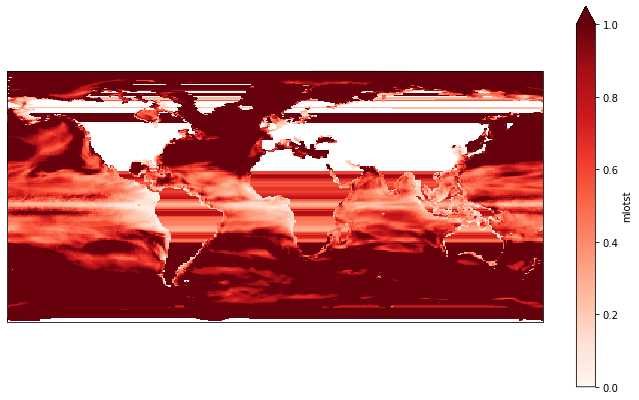

In [6]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
var_ungrid.plot.pcolormesh(ax=ax, x='lon', y='lat', vmin=0,vmax=1, cmap='Reds')

In [7]:
test_mlotst_out = xe.util.grid_global(2,2, lon1=360)
test_mlotst_out

<xarray.Dataset>
Dimensions:  (y: 90, x: 180, y_b: 91, x_b: 181)
Coordinates:
    lon      (y, x) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon_b    (y_b, x_b) float64 0.0 2.0 4.0 6.0 8.0 ... 354.0 356.0 358.0 360.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [8]:
regridder = xe.Regridder(test_mlotst, test_mlotst_out, "bilinear", ignore_degenerate=True)
test_regridded_out = regridder(test_mlotst["mlotst"])
test_regridded_out

<xarray.DataArray (time: 6000, y: 90, x: 180)>
dask.array<_regrid, shape=(6000, 90, 180), dtype=float32, chunksize=(468, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon      (y, x) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [9]:
def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]

rolling_test = test_regridded_out.rolling(time=300,center=True).mean('time')
variability_test = rolling_test.std('time')
fin = variability_test.to_dataset(name='mlotst') #Name of variable - mlotst
xin = nc_varget(fin,'lon');
yin = nc_varget(fin,'lat');
zin = nc_varget(fin,'mlotst');

x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

#new coordinates
xout = np.arange(x0,x1+dx,dx)
yout = np.arange(y0,y1+dx,dy)

xm,ym = np.meshgrid(xout,yout)
zo = griddata((xin.values.flatten(),yin.values.flatten()),zin.values.flatten(),(xm,ym), 'nearest')

final_test = xr.DataArray(zo, dims=['lat','lon'])
final_test.coords['lon'] = xout
final_test.coords['lat'] = yout

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


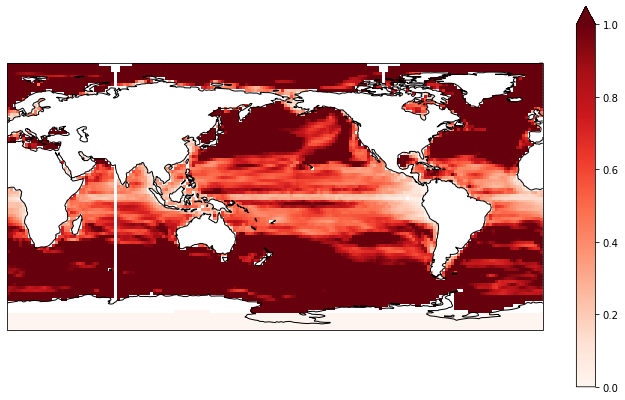

In [11]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
variability_test.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)

In [13]:
variability_test

<xarray.DataArray (y: 90, x: 180)>
dask.array<_sqrt, shape=(90, 180), dtype=float32, chunksize=(90, 180), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon      (y, x) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
Dimensions without coordinates: y, x

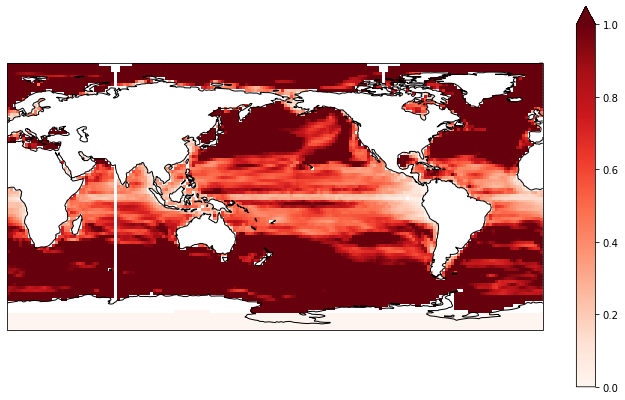

In [12]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
final_test.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)

In [14]:
final_test

<xarray.DataArray (lat: 90, lon: 180)>
array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [1.474138 , 1.4457155, 1.4242212, ..., 1.607038 , 1.55493  ,
        1.5098606],
       [1.5183147, 1.4902302, 1.4622576, ..., 1.6097026, 1.5777199,
        1.54751  ],
       [1.4292563, 1.4108605, 1.3928925, ..., 1.4841306, 1.4659888,
        1.4480423]], dtype=float32)
Coordinates:
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0

In [15]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_hml_control.zstore.values[7]
mapper = gcs.get_mapper(zstore)

test_frozen = xr.open_zarr(mapper, consolidated=True)
test_frozen

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:    (ncells: 830305, vertices: 16, time: 6000, bnds: 2)
Coordinates:
    lat        (ncells) float64 dask.array<chunksize=(830305,), meta=np.ndarray>
    lat_bnds   (ncells, vertices) float64 dask.array<chunksize=(830305, 16), meta=np.ndarray>
    lon        (ncells) float64 dask.array<chunksize=(830305,), meta=np.ndarray>
    lon_bnds   (ncells, vertices) float64 dask.array<chunksize=(830305, 16), meta=np.ndarray>
  * time       (time) object 2401-01-16 12:00:00 ... 2900-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: ncells, vertices, bnds
Data variables:
    mlotst     (time, ncells) float32 dask.array<chunksize=(25, 830305), meta=np.ndarray>
Attributes: (12/42)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  182622.0
    creation_date:          2018-12-18T12:00:00Z
    ...                     ...
    tracking_id:            hdl:21.14100/f2096e7a-80e3-4497-8818-1148b6c5a967...
    variable_id:            mlotst
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/f2096e7a-80e3-4497-8818-1148b6c5a967...
    version_id:             v20181218